<h1 style="color:rgb(0,120,170)">Assignment 1: Estimation Theory, Fisher Information, CRLB</h1>

This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

Let us start with some preliminary facts and intuition on why it is often a good idea to use the logarithm in optimization tasks, like parameter estimation:

* log is strictly monotonically increasing, so log likelihood is a strictly monotonically increasing transformation of likelihood and maxima occur at same parameter values
    * $p(x;\theta_1) > p(x;\theta_2) \Leftrightarrow \ln p(x;\theta_1) > \ln p(x;\theta_2)$
    * $\textrm{argmax}_\theta\ p(x;\theta) = \textrm{argmax}_\theta \ln p(x;\theta)$    
* products become sums
    * $L = p_1 p_2 p_3$
    * $\ln(L) = \ln(p_1) + \ln(p_2) + \ln(p_3)$
* derivatives are easier
    * $\frac{\partial L}{\partial \theta} = 
    \frac{\partial p_1}{\partial \theta} p_2 p_3 +
    p_1 \frac{\partial p_2}{\partial \theta} p_3 +
    p_1 p_2 \frac{\partial p_3}{\partial \theta}
    $
    * $\frac{\partial \ln(L)}{\partial \theta} = 
    \frac{\partial \ln(p_1)}{\partial \theta} +
    \frac{\partial \ln(p_2)}{\partial \theta} + 
    \frac{\partial \ln(p_3)}{\partial \theta}$
* likelihoods become very small and consequently they run out of floating point precision very quickly
    * log likelihoods are numerically more stable
* for some distributions the log space avoids expansive computation
    * exp in gaussian pdf:
        * $p(x; \theta) = \frac{1}{(\sqrt{2\pi})^{d}\sqrt{det \Sigma}}\,\exp^{-\frac{1}{2}(x-\mu)^{T}\Sigma^{-1}(x-\mu)}$
    * no exp in log space:
        * $\ln p(x; \theta) = -\frac{d}{2}\ln(2\pi) -\frac{1}{2}\ln(\textrm{det} \Sigma) - \frac{1}{2}(x-\mu)^{T}\Sigma^{-1}(x-\mu)$

Let us also briefly visualize the situation with a plot of the log-likelihood vs. the actual likelihood. You should see that the logarithm is just a monotonic function, so it doesn't change the actual optimization problem at hand.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

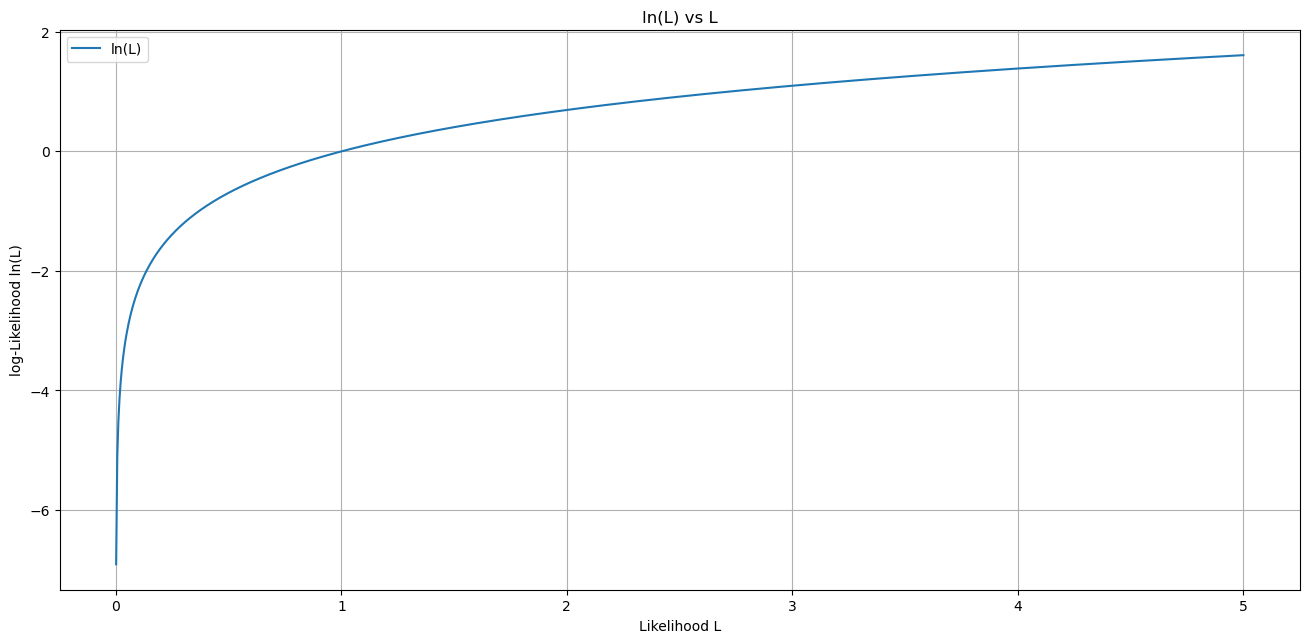

In [3]:
# plot of likelihood vs. log-likelihood

L = np.linspace(0.001,5,1000)
L_ln = np.log(L)

fig = plt.figure(figsize=(16,16))
plt.subplot(2,1,1)
plt.plot(L, L_ln, label='ln(L)')
plt.xlabel('Likelihood L')
plt.ylabel('log-Likelihood ln(L)')
plt.grid()
plt.legend()
plt.title("ln(L) vs L")
plt.show();

Consider a sequence of independent and identically distributed (i.i.d.) random variables $x_{1}, x_{2},...,x_{n}$ that are sampled from a normal distribution with an unknown expectation parameter $\mu$ and a known standard deviation parameter $\sigma$, i.e.
$x_{i}$ are distributed according to the density function

$$
p(x;\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^{2}}}\, \text{exp}^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}
$$

Let us start this task by creating 3 normally distributed datasets with same $\mu = 5$ but different $\sigma = 1,3,10$.
We also want to visualize their histograms and compare with the actual densities. The procedure should be clearly visible from the code below.

In [4]:
def gauss_function(x, mu, sigma):
    """ This is the 1D gaussian probability density function with mean mu and standard deviation sigma """
    
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))

In [5]:
def generate_data(mu, sigma, samples):
    """ This funtion generates the data """
    
    x = np.linspace(-15,25,samples)
    
    # get density over x
    density = gauss_function(x, mu, sigma)
    
    # sample for the gaussian distribution
    X_samples = sigma*np.random.randn(samples) + mu
    
    return x, density, X_samples

In [6]:
# here we generate 3 datasets with 500 samples each with same mu = 5 but different sigmas = 1,3,10

n = 500
mu = 5.0
sigma_1 = 1.0
sigma_2 = 3.0
sigma_3 = 10.0

x, p1, X1 = generate_data(mu, sigma_1, samples=n)
_, p2, X2 = generate_data(mu, sigma_2, samples=n)
_, p3, X3 = generate_data(mu, sigma_3, samples=n)

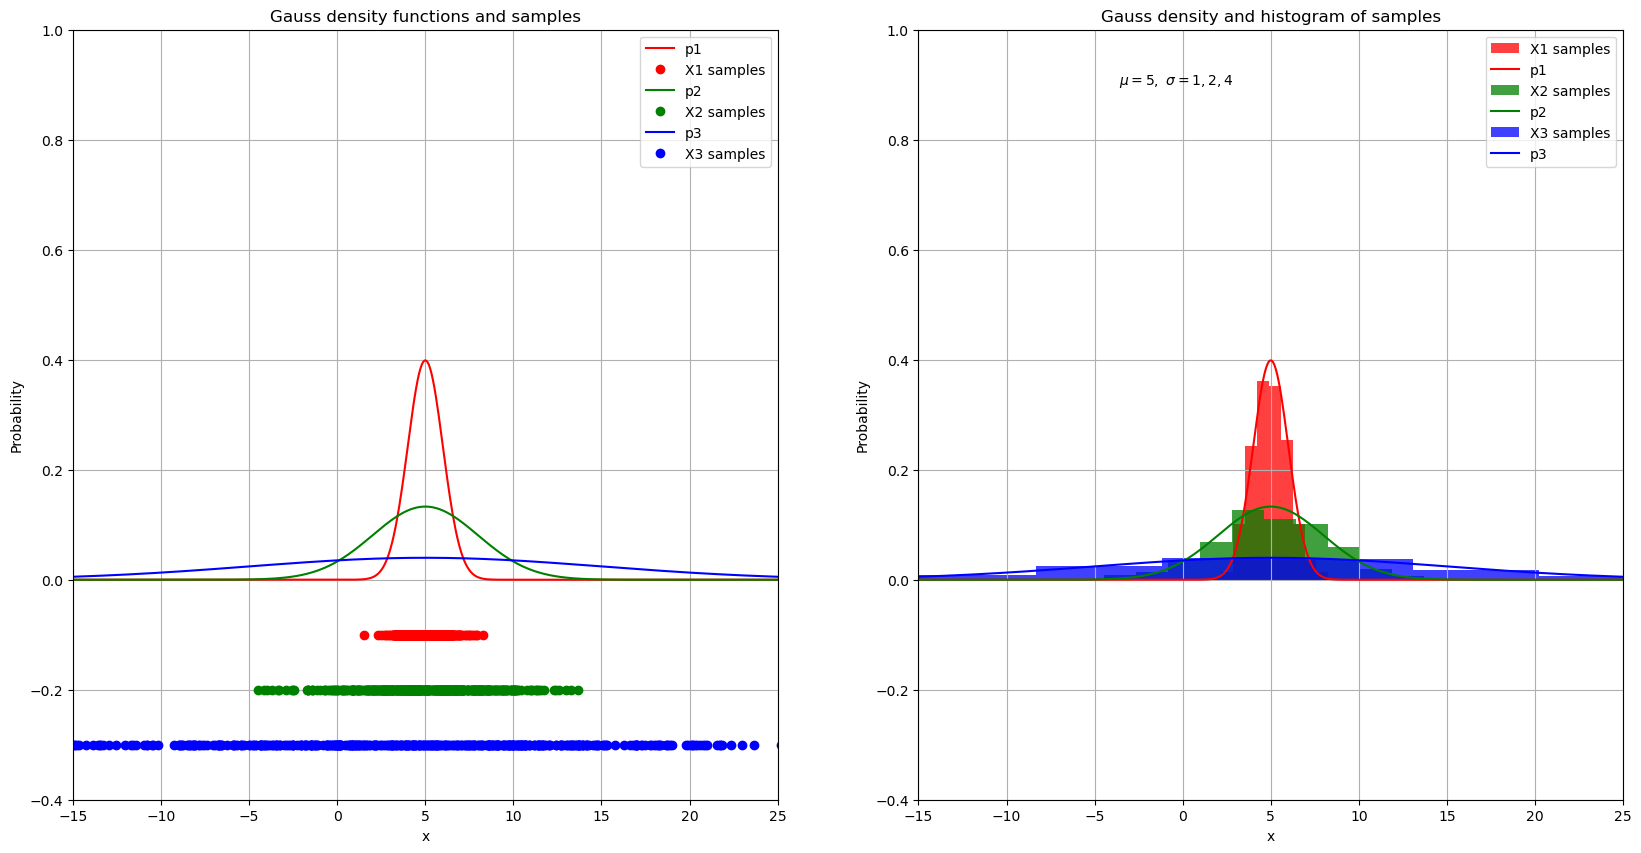

In [7]:
# this code is only for plotting

fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(x, p1, label='p1', color='r')
plt.plot(X1, np.repeat(-0.1, len(x)), 'ro', label='X1 samples')
plt.plot(x, p2, label='p2', color='g')
plt.plot(X2, np.repeat(-0.2, len(x)), 'go', label='X2 samples')
plt.plot(x, p3, label='p3', color='b')
plt.plot(X3, np.repeat(-0.3, len(x)), 'bo', label='X3 samples')
plt.axis([-15, 25, -0.4, 1.0])
plt.grid()
plt.title('Gauss density functions and samples')
plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()

# the histogram of the data

plt.subplot(1,2,2)
n, bins, patches = plt.hist(X1, density=True, facecolor='r', alpha=0.75, label='X1 samples')
plt.plot(x, p1, label='p1', color='r')
n, bins, patches = plt.hist(X2, density=True, facecolor='g', alpha=0.75, label='X2 samples')
plt.plot(x, p2, label='p2', color='g')
n, bins, patches = plt.hist(X3, density=True, facecolor='b', alpha=0.75, label='X3 samples')
plt.plot(x, p3, label='p3', color='b')
plt.legend()

plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Gauss density and histogram of samples')
plt.text(-3.6, 0.9, r'$\mu=5,\ \sigma=1,2,4$')
plt.axis([-15, 25, -0.4, 1.0])
plt.grid(True)
plt.show()

Next we want to work with the likelihood and log-likelihood of the previously created data. To this end, recall the following definitions:

**Likelihood:**
$$\mathcal{L}(w) = \prod_{i=1}^n p(x_i ; w)$$

**Log-Likelihood:**
$$\ln\mathcal{L}(w) = \sum_{i=1}^n \ln p(x_i ; w)$$

<h3 style="color:rgb(208,90,80)">Exercise 1 (10 points)</h3>

As a first task, implement the log-likelihood function for a given dataset, a given $\mu$ and a given $\sigma$, using the previously implemented functions. Test your function by executing the print commands below.

In [13]:
# Calculate the log-likehood function; it should return a scalar value

def log_likelihood(data, mu, sigma):
    """ Calculates the log likelihood"""
    
    ########## YOUR SOLUTION HERE ##########
    n = len(data)
    lnL = -n/2*np.log(2*np.pi) - n/2*np.log(sigma**2) 
   
    for xi in data:
        lnL+= -1/(2*sigma**2)*((xi - mu)**2)
        
    return lnL

In [14]:
print("ln(L)(X1,mu=5,sigma1) = %8.1f" % log_likelihood(X1, mu=5, sigma=sigma_1))
print("ln(L)(X1,mu=5,sigma2) = %8.1f" % log_likelihood(X1, mu=5, sigma=sigma_2))
print("ln(L)(X1,mu=5,sigma3) = %8.1f" % log_likelihood(X1, mu=5, sigma=sigma_3))
print("\n")
print("ln(L)(X2,mu=5,sigma1) = %8.1f" % log_likelihood(X2, mu=5, sigma=sigma_1))
print("ln(L)(X2,mu=5,sigma2) = %8.1f" % log_likelihood(X2, mu=5, sigma=sigma_2))
print("ln(L)(X2,mu=5,sigma3) = %8.1f" % log_likelihood(X2, mu=5, sigma=sigma_3))
print("\n")
print("ln(L)(X3,mu=5,sigma1) = %8.1f" % log_likelihood(X3, mu=5, sigma=sigma_1))
print("ln(L)(X3,mu=5,sigma2) = %8.1f" % log_likelihood(X3, mu=5, sigma=sigma_2))
print("ln(L)(X3,mu=5,sigma3) = %8.1f" % log_likelihood(X3, mu=5, sigma=sigma_3))

ln(L)(X1,mu=5,sigma1) =   -717.2
ln(L)(X1,mu=5,sigma2) =  -1037.4
ln(L)(X1,mu=5,sigma3) =  -1613.3


ln(L)(X2,mu=5,sigma1) =  -2981.9
ln(L)(X2,mu=5,sigma2) =  -1289.0
ln(L)(X2,mu=5,sigma3) =  -1636.0


ln(L)(X3,mu=5,sigma1) = -25435.5
ln(L)(X3,mu=5,sigma2) =  -3783.9
ln(L)(X3,mu=5,sigma3) =  -1860.5


You should be able to see that the log-likelihood for data set $X_i$ is largest for $\sigma_i$.

Now let us gain some intuition on how the log-likelihood function behaves, if data and $\sigma$ are given, but $\mu$ varies in the set $[-5,15]$. 

<h3 style="color:rgb(0,120,170)">Exercise 2 (20 Points)</h3>

Your task is to complete the implementation of the function `calculate_log_likelihood_over_mu` so that it outputs the list `mu_set` (which has already been created) and an array `lnL_array`. This array should contain the log-likelihoods calculated from data set $X$, $\sigma$ and $\mu_i$. Afterwards, compute the estimators $\hat{\mu}$ (argmax) and execute the plotting routine for the different values of $\sigma$.

In [ ]:
def calculate_log_likelihood_over_mu(data, sigma):
    
    mu_set = np.linspace(-5,15,501)
    lnL_list = []

    ########## YOUR SOLUTION HERE ##########
    lnL_list = [log_likelihood(data,mu,sigma) for mu in mu_set]
    
    lnL_array = np.array(lnL_list)
    return mu_set, lnL_array

In [ ]:
mu_set, lnL_array1 = calculate_log_likelihood_over_mu(X1, sigma_1)
_, lnL_array2 = calculate_log_likelihood_over_mu(X2, sigma_2)
_, lnL_array3 = calculate_log_likelihood_over_mu(X3, sigma_3)

In [ ]:
print("mu-hat = argmax_mu(lnL(X1,mu,sigma1)): %4.2f" % mu_set[np.argmax(lnL_array1)])
print("mu-hat = argmax_mu(lnL(X2,mu,sigma2)): %4.2f" % mu_set[np.argmax(lnL_array2)])
print("mu-hat = argmax_mu(lnL(X3,mu,sigma3)): %4.2f" % mu_set[np.argmax(lnL_array3)])

mu-hat = argmax_mu(lnL(X1,mu,sigma1)): 4.96
mu-hat = argmax_mu(lnL(X2,mu,sigma2)): 5.00
mu-hat = argmax_mu(lnL(X3,mu,sigma3)): 5.44


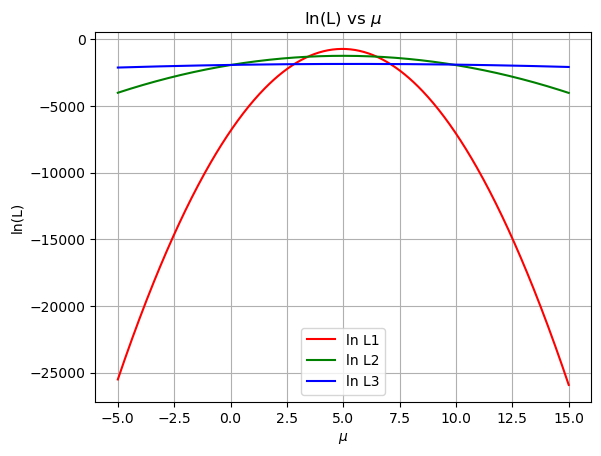

In [ ]:
plt.plot(mu_set, lnL_array1, label='ln L1', color='r')
plt.plot(mu_set, lnL_array2, label='ln L2', color='g')
plt.plot(mu_set, lnL_array3, label='ln L3', color='b')
plt.grid()
plt.legend()
plt.title("ln(L) vs $\mu$")
plt.ylabel("ln(L)")
plt.xlabel('$\mu$')
plt.show();

It is likely that the estimator $\hat{\mu}$ is closest to the true value $\mu = 5$ for $\sigma_1$ and deviates most for $\sigma_3$.

Run all cells again several times (including new random data from the fixed probability distribution) to get a feeling for the statistics.

<h3 style="color:rgb(0,120,170)">Exercise 3 (30 Points)</h3>

In the previous tasks you should have gained some intuition on how the variance of an unbiased estimator for $\mu$ behaves in certain situations (i.e. for different $\sigma$. Now we want to confirm these observations with a rigorous calculation on the lower bound of this variance:

* Determine/Calculate the Cramer-Rao lower bound for the variance of an unbiased estimator for the parameter $\mu$ for the situation described at the beginning of task 1.

To do this, work through the following steps:

1. Using (25), calculate the Log-Likelihood with the probability density function $p(x;\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^{2}}}\, \text{exp}^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}$ for $n$ data samples.
2. Verify equation (27) on slide 17 for this situation to simplify the calculation of $\mathbf{I}_{F}(\mu)$.
3. Use the simplified (curvature) formula (31) to calculate $\mathbf{I}_{F}(\mu)$. In our case, it will be a scalar $I_F$ as the parameter is also a scalar.
4. Calculate the $\text{CRLB}$ from the result of step 3

If you did everything right, you should end up with $\text{CRLB} = \frac{\sigma^2}{n}$

########## YOUR SOLUTION HERE ##########



1. Since our data is normally distributed and it's i.i.d., then pdf of the normal distribution is defined as:

$$
p(x_i | \mu, \sigma^2) = \sum_{i=1}^{N}\frac{1}{\sqrt{2\pi\sigma^2}}\exp\{-\frac{1}{2\sigma^2}(x_i-\mu)^2\}
$$

$$
\log p(\textbf{X} | \mu, \sigma^2) =\log \prod_{i=1}^n p(x_i | \mu, \sigma^2) =  \sum_{i=1}^{N} \log p(x_i | \mu, \sigma^2) =  -\frac{N}{2}\log 2\pi - \frac{N}{2}\log \sigma^2 - \sum_{i=1}^N\frac{1}{2 \sigma^2}(x_i-\mu)^2
$$

2. In i.i.d. data, each element is ideally equal to the mean because the data is assumed to be sampled from the same distribution, and the sample mean is an estimator of the population mean. 
$$
\frac{\partial \log p(\textbf{X} | \mu, \sigma^2)}{\partial \mu} = \frac{1}{\sigma^2} \sum_{i=1}^{N}(x_i-\mu) = \frac{N}{\sigma^2}(\hat{x}-\mu)
$$

$\qquad$ So, if the data is truly i.i.d. and the mean of the underlying distribution exists and is finite, then the sample mean will converge to the population mean as the sample size gets larger:
$$
\hat{x}=\mu
$$

$$
\frac{N}{\sigma^2}(\mu-\mu) = 0
$$

3. 
$$
I_F(\mu) = E \left[ \left( \frac{\partial \log p(\textbf{X} | \mu, \sigma^2)}{\partial \mu} \right)^2 \right] = E \left[ \left( \frac{1}{\sigma^2}\frac{\partial \sum_{i=1}^{N}(x_i-\mu)}{\partial \mu} \right)^2 \right] = \frac{1}{\sigma^4} E \left[\left(\sum_{i=1}^{N}(x_i-\mu) \right)^2\right]
$$
$\qquad$ Since Variance defined as expectation squared and equals to sigma squared, we can simplify our expression further:
$$
= \frac{1}{\sigma^4}*N*\sigma^2 = \frac{N}{\sigma^2}
$$

4. 

$$
CRLB \geq \frac{1}{I_F(\mu)} = \frac{\sigma^2}{N}
$$

<h3 style="color:rgb(0,120,170)">Exercise 4 (5 Points)</h3>

Now you are asked to implement the result of the previous task, i.e. provide a function that outputs the Fisher information for a given number $n$ of data samples and $\sigma$.

In [15]:
def fisher_information_mu(n, sigma):
    """ Calculate the fisher information  """
    
    ########## YOUR SOLUTION HERE ##########
    return n/(sigma**2)

In [16]:
print("IF(mu) with sigma1: IF = %6.2f" %fisher_information_mu(n=500,sigma=sigma_1))
print("IF(mu) with sigma2: IF = %6.2f" %fisher_information_mu(n=500,sigma=sigma_2))
print("IF(mu) with sigma3: IF = %6.2f" %fisher_information_mu(n=500,sigma=sigma_3))

IF(mu) with sigma1: IF = 500.00
IF(mu) with sigma2: IF =  55.56
IF(mu) with sigma3: IF =   5.00


<h3 style="color:rgb(0,120,170)">Exercise 5 (5 Points)</h3>

Answer some questions on your observations (2 sentences in total are enough):
* How does the variance of the estimator of the mean $\mu$ depend on standard deviation $\sigma$ and sample number $n$?
* Which values of $\sigma$ are better for estimating $\mu$?

########## YOUR SOLUTION HERE ##########
* sample number is inversely linearly dependable; standard deviation is directly non-linearly dependable;
* the smaller the better.

Now, we want to prove some basic properties of the arithmetic mean as an estimator for the mean of the sample given in task 1.

<h3 style="color:rgb(0,120,170)">Exercise 6 (15 Points)</h3>

Consider the estimator $\hat\mu = \sum_{i=1}^{n} \frac{1}{n} x_{i}$ i.e. the aritmetic mean of the observations. Show that this is an unbiased estimator for the parameter $\mu$.

########## YOUR SOLUTION HERE ##########

For an estimator to be unbiased, its expectation equals to the parameter of that expectation. 
$$
E(\hat\mu) = E \left(\sum_{i=1}^{N} \frac{1}{n} x_{i}\right) = \frac{1}{N}\sum_{i=1}^{N}E[x_i] = \frac{1}{N} \sum_{i=1}^{N}\mu = \frac{1}{N}N\mu = \mu
$$

<h3 style="color:rgb(0,120,170)">Exercise 7 (15 Points)</h3>

Check if the estimator $\hat\mu = \frac{1}{n} \sum_{i}^{n} x_{i}$ is efficient.

########## YOUR SOLUTION HERE ##########

An unbiased estimator is efficient when its variance equals the CRLB:
$$
Var(\hat{\mu}) = Var(\frac{1}{N}\sum_{i=1}^{N}x_i) = \frac{1}{N^2}N\sigma^2 = \frac{\sigma^2}{N}
$$ 
As it can be seen, it equals to the definition of CRLB in ex3
